In [1]:
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from figure8_env import MyEnv as figure8_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

In [2]:
figure8_give_rewards = True
nn_yaml = 'network_noconv.yaml'
higher_dim_obs = False
internal_dim = 2

In [3]:
class Defaults:
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 5000
    epochs = 50
    steps_per_test = 1000
    period_btw_summary_perfs = 1
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    update_rule = 'rmsprop'
    learning_rate = 5 * 1E-4 # 1E-4
    learning_rate_decay = 0.9
    discount = 0.9
    discount_inc = 1
    discount_max = 0.99
    rms_decay = 0.9
    rms_epsilon = 0.0001
    momentum = 0
    clip_norm = 1.0
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 10000
    update_frequency = 1
    replay_memory_size = 1000000 #replacing with 200000 will works just fine (in case you dont have 18gb of memory)
    batch_size = 32
    freeze_interval = 1000
    deterministic = False

In [4]:
parameters = Defaults()
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

# --- Instantiate environment ---
env = figure8_env(
    give_rewards=figure8_give_rewards,
    intern_dim=internal_dim,
    higher_dim_obs=higher_dim_obs,
    )

# --- Instantiate learning_algo ---
learning_algo = CRAR(
    env,
    parameters.rms_decay,
    parameters.rms_epsilon,
    parameters.momentum,
    parameters.clip_norm,
    parameters.freeze_interval,
    parameters.batch_size,
    parameters.update_rule,
    rng,
    high_int_dim=False,
    internal_dim=internal_dim, lr=parameters.learning_rate,
    nn_yaml=nn_yaml, double_Q=True
    )

if figure8_give_rewards:
    train_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng, epsilon=0.2
        )
    test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)
else:
    train_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng, epsilon=0.2
        )
    test_policy = FixedFigure8Policy.FixedFigure8Policy(learning_algo, env.nActions(), rng)

# --- Instantiate agent ---
agent = NeuralAgent(
    env,
    learning_algo,
    parameters.replay_memory_size,
    1,
    parameters.batch_size,
    rng,
    train_policy=train_policy,
    test_policy=test_policy)

# --- Create unique filename for FindBestController ---
h = hash(vars(parameters), hash_name="sha1")
fname = "test_" + h
print("The parameters hash is: {}".format(h))
print("The parameters are: {}".format(parameters))

# As for the discount factor and the learning rate, one can update periodically the parameter of the epsilon-greedy
# policy implemented by the agent. This controllers has a bit more capabilities, as it allows one to choose more
# precisely when to update epsilon: after every X action, episode or epoch. This parameter can also be reset every
# episode or epoch (or never, hence the resetEvery='none').
agent.attach(bc.EpsilonController(
    initial_e=parameters.epsilon_start,
    e_decays=parameters.epsilon_decay,
    e_min=parameters.epsilon_min,
    evaluate_on='action',
    periodicity=1,
    reset_every='none'))

agent.run(10, 500)
print("end gathering data")

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# Every epoch end, one has the possibility to modify the learning rate using a LearningRateController. Here we 
# wish to update the learning rate after every training epoch (periodicity=1), according to the parameters given.
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# Same for the discount factor.
agent.attach(bc.DiscountFactorController(
    initial_discount_factor=parameters.discount, 
    discount_factor_growth=parameters.discount_inc, 
    discount_factor_max=parameters.discount_max,
    periodicity=1))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=figure8_env.VALIDATION_MODE,
    testID=None,
    unique_fname=fname))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch. For each validation epoch, we want also to display the sum of all 
# rewards obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env 
# every [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=figure8_env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1))

The parameters hash is: 62977be8e45d8a56a5537c11dfd5d2fd8dda69e0
The parameters are: <__main__.Defaults object at 0x2b3f795f9a60>
end gathering data


In [5]:
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
agent.gathering_data=False
agent.run(parameters.epochs, parameters.steps_per_epoch)

# --- Show results ---
basename = "scores/" + fname
scores = load(basename + "_scores.jldump")
print (scores)

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0185,  0.2836], device='cuda:0') tensor([0.2966, 0.1244], device='cuda:0') tensor([-0.0185,  0.2836], device='cuda:0')
R[0]
tensor([-0.0164], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.05057600834593177 0.004148034423681566 0.03504039069202554 0.020756379073252902 0.5623702617883682 0.0001052953600883484 0.0905155915506184
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.1733,  0.3038], device='cuda:0') tensor([-0.0864,  0.2642], device='cuda:0') tensor([-0.0687,  0.0429], device='cuda:0')
R[0]
tensor([0.0078], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, s

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/share/ctn/users/cf2794/Code/deer/deer/learning_algos/CRAR_torch.py:393: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  state = torch.as_tensor(state, device=self.device).float()


Testing score per episode (id: 0) is 1.0 (average over 1 episode(s))
== Mean score per episode is 0.9999000099990001 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9757,  0.6303], device='cuda:0') tensor([-0.9327,  0.3054], device='cuda:0') tensor([-0.9466,  0.1894], device='cuda:0')
R[0]
tensor([0.0123], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007567390185315162 0.004114095564640593 0.001458784739148541 0.004322578106512083 0.5688917735815048 0.00018369866162538527 0.045839990749023854
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.7437,  0.7597], device='cuda:0') tensor([-0.8780,  0.7587], device='cuda:0') tensor([-0.7437,  0.7597], device='cuda:0')
R[0]
tensor([0.0072], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_ga

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5630,  0.0764], device='cuda:0') tensor([-0.5281,  0.0717], device='cuda:0') tensor([-0.5630,  0.0764], device='cuda:0')
R[0]
tensor([-0.0006], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.005360889739822596 0.0043455361367850855 0.0012024916346936151 0.004499225469597149 0.5682101622223854 9.758219122886658e-05 0.04659746692655608
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.1487, 0.6211], device='cuda:0') tensor([0.3517, 0.6863], device='cuda:0') tensor([0.1487, 0.6211], device='cuda:0')
R[0]
tensor([0.0061], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.1553, 0.5805], device='cuda:0') tensor([0.1967, 0.8579], device='cuda:0') tensor([0.3116, 0.9750], device='cuda:0')
R[0]
tensor([0.0111], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.004552033103536814 0.004399288785574754 0.0015965081119011302 0.004485328401628067 0.5629120089411735 6.82884156703949e-05 0.045933594827074556
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.7160, -0.9883], device='cuda:0') tensor([ 0.4140, -0.9806], device='cuda:0') tensor([ 0.3786, -0.9911], device='cuda:0')
R[0]
tensor([0.0023], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, se

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5536, -0.2895], device='cuda:0') tensor([-0.5851, -0.2715], device='cuda:0') tensor([-0.5536, -0.2895], device='cuda:0')
R[0]
tensor([-0.0013], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0035639677371364087 0.00421312414347085 0.0018499056034327168 0.004306933520667371 0.5607681741118431 6.343046575784684e-05 0.0483102344754152
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.8626,  0.9962], device='cuda:0') tensor([-0.8540,  0.9974], device='cuda:0') tensor([-0.8626,  0.9962], device='cuda:0')
R[0]
tensor([-0.0021], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_ga

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.1103,  0.9943], device='cuda:0') tensor([0.3208, 0.9690], device='cuda:0') tensor([0.2999, 0.9700], device='cuda:0')
R[0]
tensor([0.0084], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0032009881287813186 0.0031000910515140276 0.0014364231601391565 0.003228739386635425 0.5654257097244263 4.626820236444473e-05 0.046440758239477874
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9944,  0.1577], device='cuda:0') tensor([-0.9917,  0.5245], device='cuda:0') tensor([-1.0004,  0.5633], device='cuda:0')
R[0]
tensor([-0.0039], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gam

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.1131, 0.9942], device='cuda:0') tensor([0.0475, 0.9594], device='cuda:0') tensor([0.1131, 0.9942], device='cuda:0')
R[0]
tensor([-0.0017], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.002790117067983374 0.004377811251666572 0.0011746228635088301 0.004469694505343796 0.5630399559140206 4.0270090103149414e-05 0.04716376111004501
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9978, -0.1593], device='cuda:0') tensor([ 0.9939, -0.5438], device='cuda:0') tensor([ 0.9958, -0.5852], device='cuda:0')
R[0]
tensor([-0.0011], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma,

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.7663, 0.9936], device='cuda:0') tensor([0.7650, 0.9927], device='cuda:0') tensor([0.7663, 0.9936], device='cuda:0')
R[0]
tensor([0.0139], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00231364393804688 0.00468252763280907 0.0016821626754483531 0.004767784876166843 0.559192506313324 4.492802172899246e-05 0.04784305680729449
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9997,  0.1359], device='cuda:0') tensor([-1.0005,  0.1368], device='cuda:0') tensor([-0.9997,  0.1359], device='cuda:0')
R[0]
tensor([-0.0027], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9983, 0.9972], device='cuda:0') tensor([0.7458, 0.9586], device='cuda:0') tensor([0.7260, 0.9987], device='cuda:0')
R[0]
tensor([0.0209], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.002260621989495121 0.004317452714367391 0.0014780342509104684 0.004387725184293231 0.5657417243719101 3.6320030689239505e-05 0.045126999302767215
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9967, -0.5963], device='cuda:0') tensor([-0.9403, -0.5674], device='cuda:0') tensor([-0.9967, -0.5963], device='cuda:0')
R[0]
tensor([0.0082], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5544,  0.9959], device='cuda:0') tensor([-0.5361,  1.0215], device='cuda:0') tensor([-0.5544,  0.9959], device='cuda:0')
R[0]
tensor([0.0067], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001964202685863711 0.00431098221612774 0.0015759669047758962 0.004395014201654703 0.5608245139718055 2.928803861141205e-05 0.04585827287938446
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6419, -0.9979], device='cuda:0') tensor([ 0.3232, -0.9860], device='cuda:0') tensor([ 0.3032, -0.9970], device='cuda:0')
R[0]
tensor([-0.0012], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gam

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6078, -0.5108], device='cuda:0') tensor([-0.5851, -0.5245], device='cuda:0') tensor([-0.6078, -0.5108], device='cuda:0')
R[0]
tensor([0.0004], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001858937111333944 0.0038838026392022584 0.0016260333567448698 0.0039625595102406805 0.5550190114378929 2.5337927043437958e-05 0.04577197013236582
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 1.0000, -0.3629], device='cuda:0') tensor([0.9965, 0.0219], device='cuda:0') tensor([1.0000, 0.0346], device='cuda:0')
R[0]
tensor([-0.0025], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gam

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.7060, 1.0001], device='cuda:0') tensor([0.4759, 0.7910], device='cuda:0') tensor([0.5504, 0.7079], device='cuda:0')
R[0]
tensor([0.0186], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0019005680084228517 0.003638633529761137 0.0016195025051936227 0.0037226995900564363 0.551614002943039 1.9410684704780577e-05 0.04490782444784418
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2900, -0.9973], device='cuda:0') tensor([-0.0544, -1.0026], device='cuda:0') tensor([ 0.0241, -0.8256], device='cuda:0')
R[0]
tensor([0.0002], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2893,  0.5379], device='cuda:0') tensor([-0.3802,  0.6019], device='cuda:0') tensor([-0.2893,  0.5379], device='cuda:0')
R[0]
tensor([0.0004], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0016610278357984498 0.003997896805933124 0.0012666842731512134 0.004031979786028387 0.5558034329414367 2.0611882209777832e-05 0.04462597794597969
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.4972, 0.3443], device='cuda:0') tensor([ 0.5031, -0.1131], device='cuda:0') tensor([ 0.6371, -0.0507], device='cuda:0')
R[0]
tensor([-0.0018], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_ga

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5010,  0.4420], device='cuda:0') tensor([-0.4992,  0.4515], device='cuda:0') tensor([-0.5010,  0.4420], device='cuda:0')
R[0]
tensor([-0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0015998344953986816 0.0038273151831872384 0.001621033617888088 0.003931029404004221 0.5474028500914574 2.1730899810791016e-05 0.04408295664191246
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2482, -0.9988], device='cuda:0') tensor([ 0.0771, -0.9621], device='cuda:0') tensor([ 0.0173, -0.8548], device='cuda:0')
R[0]
tensor([0.0078], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4596, -0.1877], device='cuda:0') tensor([-0.4437, -0.1944], device='cuda:0') tensor([-0.4596, -0.1877], device='cuda:0')
R[0]
tensor([-0.0045], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0014350792276090942 0.00434933345463287 0.001014415716174426 0.0043599282293434955 0.5508702556490899 1.4330804347991944e-05 0.04520835759723559
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.3843, 0.6399], device='cuda:0') tensor([0.3697, 0.1471], device='cuda:0') tensor([0.3445, 0.1890], device='cuda:0')
R[0]
tensor([-0.0011], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma,

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6684, -0.9987], device='cuda:0') tensor([-0.6266, -0.9963], device='cuda:0') tensor([-0.6684, -0.9987], device='cuda:0')
R[0]
tensor([0.0081], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0014194994054269046 0.003762367803543384 0.0019142747277444414 0.0038930980842123973 0.5572693670392036 1.436731219291687e-05 0.044193528497591616
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.5079, 0.9995], device='cuda:0') tensor([0.9116, 0.9100], device='cuda:0') tensor([0.9988, 0.9978], device='cuda:0')
R[0]
tensor([0.0118], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma,

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9989, -0.1429], device='cuda:0') tensor([ 1.0165, -0.1341], device='cuda:0') tensor([ 0.9989, -0.1429], device='cuda:0')
R[0]
tensor([0.0031], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0013149970984086394 0.004725442863673379 0.0011152287670456644 0.0047341375793330375 0.5539815544486045 1.3826325535774231e-05 0.04479294882155955
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6030, -0.9993], device='cuda:0') tensor([ 0.6607, -0.9945], device='cuda:0') tensor([ 0.6030, -0.9993], device='cuda:0')
R[0]
tensor([0.0060], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5045,  0.9989], device='cuda:0') tensor([-0.9937,  0.9883], device='cuda:0') tensor([-0.9995,  0.9988], device='cuda:0')
R[0]
tensor([8.9207e-06], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001330483571626246 0.004174307029963529 0.001467888665496048 0.004275671350027551 0.5492269005179405 1.5736810863018037e-05 0.04574518672190606
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9433, -0.9984], device='cuda:0') tensor([-0.9776, -1.0091], device='cuda:0') tensor([-0.9433, -0.9984], device='cuda:0')
R[0]
tensor([0.0126], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9993, -0.1800], device='cuda:0') tensor([-0.9898, -0.1820], device='cuda:0') tensor([-0.9993, -0.1800], device='cuda:0')
R[0]
tensor([0.0014], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00128585844009649 0.0038092212691772146 0.0009114847527798702 0.0039083476940722905 0.5520659248232842 1.0866515338420868e-05 0.04428921514842659
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9993, 0.6506], device='cuda:0') tensor([0.9702, 0.9392], device='cuda:0') tensor([0.9996, 0.9989], device='cuda:0')
R[0]
tensor([0.0128], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.3069, 0.5678], device='cuda:0') tensor([0.4786, 0.9101], device='cuda:0') tensor([0.4898, 0.9988], device='cuda:0')
R[0]
tensor([0.0122], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0012707481267862021 0.004053956447110977 0.001816745114498417 0.004209394891615375 0.5468072476387024 1.1815011501312257e-05 0.04622947457339615
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3693, -0.9989], device='cuda:0') tensor([-0.6899, -0.9781], device='cuda:0') tensor([-0.6677, -0.9994], device='cuda:0')
R[0]
tensor([0.0033], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, s

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 1.0000, -0.3846], device='cuda:0') tensor([ 1.0237, -0.3822], device='cuda:0') tensor([ 1.0000, -0.3846], device='cuda:0')
R[0]
tensor([0.0028], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0012094673528335988 0.003876605909996215 0.0015148381187545966 0.004015701495547546 0.548587503015995 1.0019145905971528e-05 0.04476172126596793
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9993, 0.6424], device='cuda:0') tensor([1.0091, 0.6386], device='cuda:0') tensor([0.9993, 0.6424], device='cuda:0')
R[0]
tensor([-0.0035], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1378, -0.9948], device='cuda:0') tensor([-0.1754, -0.9892], device='cuda:0') tensor([-0.1814, -0.9998], device='cuda:0')
R[0]
tensor([-0.0048], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0011881453979876823 0.003879056372359628 0.0015669278716570717 0.004064105137484148 0.5531654646396637 7.982730865478515e-06 0.04386681278701872
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.7334, -0.5090], device='cuda:0') tensor([ 0.7561, -0.4888], device='cuda:0') tensor([ 0.7334, -0.5090], device='cuda:0')
R[0]
tensor([0.0082], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_g

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5792, -0.9994], device='cuda:0') tensor([-0.5744, -1.0439], device='cuda:0') tensor([-0.5792, -0.9994], device='cuda:0')
R[0]
tensor([-5.2527e-05], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0012385372744174673 0.004713319779231825 0.0016668445703296583 0.004833655297697987 0.5498532756567002 6.383277475833893e-06 0.04469531169813126
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2395, -0.3683], device='cuda:0') tensor([-0.2612, -0.4087], device='cuda:0') tensor([-0.2395, -0.3683], device='cuda:0')
R[0]
tensor([-0.0036], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.l

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9988,  0.9998], device='cuda:0') tensor([-1.0020,  0.9996], device='cuda:0') tensor([-0.9988,  0.9998], device='cuda:0')
R[0]
tensor([0.0033], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0011570851632859557 0.0041036109770211625 0.001414119229785001 0.004239324128517182 0.5488013672232628 6.560809910297394e-06 0.04529878757102415
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4724, -0.0863], device='cuda:0') tensor([-0.0448,  0.0503], device='cuda:0') tensor([-0.0065,  0.0603], device='cuda:0')
R[0]
tensor([-0.0059], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_g

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9285, 1.0001], device='cuda:0') tensor([0.9939, 0.7368], device='cuda:0') tensor([0.9991, 0.7078], device='cuda:0')
R[0]
tensor([0.0005], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010937043765443376 0.0040232042258612636 0.0014660367244214284 0.0041942264591052665 0.553418432533741 5.649529397487641e-06 0.04589638742245734
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.5878, 0.9995], device='cuda:0') tensor([0.5779, 0.9942], device='cuda:0') tensor([0.5878, 0.9995], device='cuda:0')
R[0]
tensor([0.0057], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.l

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2680, -0.9990], device='cuda:0') tensor([-0.2774, -0.9926], device='cuda:0') tensor([-0.2680, -0.9990], device='cuda:0')
R[0]
tensor([0.0035], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0011060688869329168 0.003689377049639006 0.001966403898641147 0.0038830535754095763 0.5490909413695335 5.445986986160278e-06 0.04327453365176916
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9998, -0.3931], device='cuda:0') tensor([ 0.9965, -0.3886], device='cuda:0') tensor([ 0.9998, -0.3931], device='cuda:0')
R[0]
tensor([0.0001], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_ga

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6131, -0.9996], device='cuda:0') tensor([ 0.9816, -1.0158], device='cuda:0') tensor([ 0.9998, -0.9997], device='cuda:0')
R[0]
tensor([0.0240], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0011018518415512517 0.004352122338867048 0.0008095279696898387 0.00442292810435174 0.548920591711998 5.265861749649048e-06 0.04425181665085256
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.5879, 0.4965], device='cuda:0') tensor([0.6120, 0.9842], device='cuda:0') tensor([0.6016, 0.9993], device='cuda:0')
R[0]
tensor([0.0098], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, sel

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9997, 0.0367], device='cuda:0') tensor([1.0011, 0.0291], device='cuda:0') tensor([0.9997, 0.0367], device='cuda:0')
R[0]
tensor([-0.0047], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010586181133403444 0.004241214287008916 0.0019166842788224585 0.004433548649714794 0.5549773548841477 4.349358379840851e-06 0.044593076932244
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9998,  0.5775], device='cuda:0') tensor([-1.0062,  0.5740], device='cuda:0') tensor([-0.9998,  0.5775], device='cuda:0')
R[0]
tensor([-0.0053], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, s

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0278, -0.4429], device='cuda:0') tensor([-0.0681, -0.4614], device='cuda:0') tensor([-0.0278, -0.4429], device='cuda:0')
R[0]
tensor([-0.0062], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00108457773149712 0.004325562376841845 0.0014653626844753943 0.00449206060403958 0.54592023062706 3.9785504341125485e-06 0.04481947794463485
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6918, -0.9999], device='cuda:0') tensor([-0.6432, -0.9298], device='cuda:0') tensor([-0.6918, -0.9999], device='cuda:0')
R[0]
tensor([0.0045], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.2632, 0.9990], device='cuda:0') tensor([0.5359, 0.4990], device='cuda:0') tensor([0.5691, 0.4866], device='cuda:0')
R[0]
tensor([0.0184], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00110523044684669 0.00377142058089521 0.001815628875766606 0.0039391225650324485 0.5510623353719711 3.5166367888450623e-06 0.045747134515084324
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9999, -0.1460], device='cuda:0') tensor([ 1.0099, -0.1452], device='cuda:0') tensor([ 0.9999, -0.1460], device='cuda:0')
R[0]
tensor([0.0003], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, se

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0417, -0.7862], device='cuda:0') tensor([ 0.3974, -0.5941], device='cuda:0') tensor([ 0.3433, -0.6298], device='cuda:0')
R[0]
tensor([-0.0034], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010772104895440861 0.003992827908248728 0.001112101391801616 0.004104942849458894 0.5506140214800834 3.147616982460022e-06 0.044200595011934636
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 1.0000, -0.3855], device='cuda:0') tensor([ 1.0160, -0.3852], device='cuda:0') tensor([ 1.0000, -0.3855], device='cuda:0')
R[0]
tensor([-0.0020], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.8319, 0.9999], device='cuda:0') tensor([0.8214, 0.9858], device='cuda:0') tensor([0.8319, 0.9999], device='cuda:0')
R[0]
tensor([0.0042], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010031216209172272 0.0038339782628427203 0.001614951238523645 0.004044808973092586 0.5533896315097809 2.677306532859802e-06 0.04564793597068638
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9283, -0.9996], device='cuda:0') tensor([-0.5568, -0.3375], device='cuda:0') tensor([-0.5370, -0.2517], device='cuda:0')
R[0]
tensor([0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, s

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.5540, 0.0135], device='cuda:0') tensor([ 0.5578, -0.0023], device='cuda:0') tensor([0.5540, 0.0135], device='cuda:0')
R[0]
tensor([0.0124], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00109778865496628 0.004255449600892461 0.0014136913735842427 0.004375314383127261 0.5507542091608048 2.9637739062309265e-06 0.04502350311120972
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3463, -0.6291], device='cuda:0') tensor([-0.0412, -0.7102], device='cuda:0') tensor([-0.0468, -0.7849], device='cuda:0')
R[0]
tensor([0.0013], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.8503,  0.9997], device='cuda:0') tensor([-0.8333,  0.9947], device='cuda:0') tensor([-0.8503,  0.9997], device='cuda:0')
R[0]
tensor([-0.0043], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010513354252325371 0.004326057269598095 0.0015642391401061103 0.004425505845909356 0.5496574767827987 2.791367471218109e-06 0.04448313580919057
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2738, -0.9999], device='cuda:0') tensor([ 0.0342, -0.8780], device='cuda:0') tensor([-0.0432, -0.7849], device='cuda:0')
R[0]
tensor([0.0038], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_g

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.0703, 0.9999], device='cuda:0') tensor([-0.5028,  1.0375], device='cuda:0') tensor([-0.5068,  0.9999], device='cuda:0')
R[0]
tensor([0.0116], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001006905619171448 0.004183140745561104 0.0010621718880090612 0.004329136989545077 0.5500573996901512 2.0862966775894163e-06 0.04199829117581248
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9999,  0.9999], device='cuda:0') tensor([-1.0062,  0.5701], device='cuda:0') tensor([-0.9998,  0.5807], device='cuda:0')
R[0]
tensor([0.0058], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamm

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9998, 0.8309], device='cuda:0') tensor([0.9877, 0.7952], device='cuda:0') tensor([0.9998, 0.8309], device='cuda:0')
R[0]
tensor([0.0007], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010302226268104277 0.003952880072298285 0.0014131130955747722 0.004116104436994647 0.5529489839673042 2.269864082336426e-06 0.04282000279915519
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5245, -0.2343], device='cuda:0') tensor([-0.5280, -0.2441], device='cuda:0') tensor([-0.5245, -0.2343], device='cuda:0')
R[0]
tensor([-0.0012], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9998, -0.9999], device='cuda:0') tensor([ 0.6136, -0.9804], device='cuda:0') tensor([ 0.6005, -1.0000], device='cuda:0')
R[0]
tensor([-0.0020], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0009976501656346955 0.003885773547521239 0.0017632513913260937 0.004015415771355038 0.550159972012043 1.698821783065796e-06 0.044259895251132546
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9999, 0.5498], device='cuda:0') tensor([1.0033, 0.2299], device='cuda:0') tensor([0.9998, 0.2498], device='cuda:0')
R[0]
tensor([-0.0046], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma,

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2096, -0.9588], device='cuda:0') tensor([ 0.5016, -1.0025], device='cuda:0') tensor([ 0.5243, -0.9998], device='cuda:0')
R[0]
tensor([0.0152], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0009745604147028644 0.003971778684885067 0.001362434482593244 0.004116078008024488 0.5518544173836708 1.4874041080474853e-06 0.042298430897761134
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9999, 0.2559], device='cuda:0') tensor([ 1.0001, -0.1250], device='cuda:0') tensor([ 0.9998, -0.1443], device='cuda:0')
R[0]
tensor([-0.0039], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_ga

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9999, -0.2021], device='cuda:0') tensor([-1.0073, -0.1962], device='cuda:0') tensor([-0.9999, -0.2021], device='cuda:0')
R[0]
tensor([0.0044], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010369382676144597 0.004673044563554868 0.0007084214197752771 0.0047205942403816155 0.549785006582737 1.5371888875961305e-06 0.04337240291573107
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0534, -0.7762], device='cuda:0') tensor([ 0.3784, -0.5934], device='cuda:0') tensor([ 0.3453, -0.6277], device='cuda:0')
R[0]
tensor([-0.0026], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9272, -0.9999], device='cuda:0') tensor([-0.9656, -1.0035], device='cuda:0') tensor([-0.9272, -0.9999], device='cuda:0')
R[0]
tensor([0.0106], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0009880357112560887 0.0036419830824961537 0.0011612653793506525 0.0037949292756820794 0.5528485575914382 1.4414340257644654e-06 0.043428760669659824
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0535, -0.7693], device='cuda:0') tensor([ 0.1348, -0.8697], device='cuda:0') tensor([ 0.2534, -0.9699], device='cuda:0')
R[0]
tensor([0.0012], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.los

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5018,  0.9998], device='cuda:0') tensor([0.0907, 1.0102], device='cuda:0') tensor([0.0652, 0.9999], device='cuda:0')
R[0]
tensor([0.0001], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001024239206511993 0.004389589251906727 0.0014126917208757276 0.00451300621611881 0.5468453741073609 1.2009143829345703e-06 0.04632503568194807
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.7687, -0.5765], device='cuda:0') tensor([ 0.7650, -0.6094], device='cuda:0') tensor([ 0.7687, -0.5765], device='cuda:0')
R[0]
tensor([0.0142], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2511, -0.9679], device='cuda:0') tensor([ 0.2492, -0.9861], device='cuda:0') tensor([ 0.2511, -0.9679], device='cuda:0')
R[0]
tensor([-0.0058], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010044026967079844 0.0035938070963129577 0.0013622752887858952 0.0037752148613508325 0.5498587718009948 1.194879412651062e-06 0.04561076385620982
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9995,  0.1855], device='cuda:0') tensor([-0.9701,  0.1894], device='cuda:0') tensor([-0.9995,  0.1855], device='cuda:0')
R[0]
tensor([-0.0038], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.los

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6783, -0.9999], device='cuda:0') tensor([-0.3403, -1.0078], device='cuda:0') tensor([-0.3577, -0.9999], device='cuda:0')
R[0]
tensor([0.0025], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001093695299117826 0.004721864745570201 0.001462942440795132 0.004831182384761632 0.5502188504338265 7.892847061157227e-07 0.04470326072257012
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.8249, -1.0000], device='cuda:0') tensor([ 0.8237, -0.9903], device='cuda:0') tensor([ 0.8249, -1.0000], device='cuda:0')
R[0]
tensor([0.0073], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamm

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6032, -0.9999], device='cuda:0') tensor([ 0.2359, -0.9511], device='cuda:0') tensor([ 0.2501, -0.9686], device='cuda:0')
R[0]
tensor([0.0061], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0009953954360098578 0.003431584611786093 0.001915309528040325 0.0036671699738362804 0.5484087373018265 1.0060817003250121e-06 0.046111108014360074
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1386, -0.9170], device='cuda:0') tensor([ 0.4186, -1.0132], device='cuda:0') tensor([ 0.4117, -0.9999], device='cuda:0')
R[0]
tensor([0.0089], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9220, 0.9999], device='cuda:0') tensor([0.9846, 0.7467], device='cuda:0') tensor([0.9999, 0.7238], device='cuda:0')
R[0]
tensor([0.0010], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010266974575642962 0.0035718845161281936 0.0013628287586252555 0.0037785795386007523 0.5454052039384842 7.315129041671753e-07 0.0456508527379483
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2076, -0.2697], device='cuda:0') tensor([ 0.1925, -0.2758], device='cuda:0') tensor([ 0.2076, -0.2697], device='cuda:0')
R[0]
tensor([-0.0067], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma,

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5808, -0.5050], device='cuda:0') tensor([ 0.5773, -0.4958], device='cuda:0') tensor([ 0.5808, -0.5050], device='cuda:0')
R[0]
tensor([0.0222], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010124094481870998 0.004762967739017768 0.0010613616202213051 0.004795035149072646 0.5458985417485237 6.11335039138794e-07 0.04484413005132228
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2660, -1.0000], device='cuda:0') tensor([ 0.0179, -0.8474], device='cuda:0') tensor([-0.0568, -0.7627], device='cuda:0')
R[0]
tensor([0.0028], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gam

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-1.0000,  1.0000], device='cuda:0') tensor([-1.0037,  1.0055], device='cuda:0') tensor([-1.0000,  1.0000], device='cuda:0')
R[0]
tensor([-0.0037], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010653732727223541 0.004736495845863828 0.0014615751595117672 0.004810539525133209 0.5519000025987625 6.921887397766113e-07 0.045989790741354224
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6005, -1.0000], device='cuda:0') tensor([ 0.9919, -1.0106], device='cuda:0') tensor([ 1.0000, -1.0000], device='cuda:0')
R[0]
tensor([0.0310], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5913, -0.9999], device='cuda:0') tensor([-0.9156, -0.9840], device='cuda:0') tensor([-0.9264, -0.9997], device='cuda:0')
R[0]
tensor([0.0071], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0010020677701686508 0.0028797909437944325 0.0017641599900525761 0.0031229146038240286 0.5451827896237373 5.677193403244018e-07 0.04322405755706132
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3491, -0.6255], device='cuda:0') tensor([ 0.4217, -0.6733], device='cuda:0') tensor([ 0.3491, -0.6255], device='cuda:0')
R[0]
tensor([0.0182], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-1.0000, -1.0000], device='cuda:0') tensor([-0.9955, -1.0166], device='cuda:0') tensor([-1.0000, -1.0000], device='cuda:0')
R[0]
tensor([0.0175], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0009897492754389532 0.004123648714452429 0.0011610929400881105 0.0042271815726126075 0.5502627184987068 5.593001842498779e-07 0.0466231236346066
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([5.4388e-01, 1.0728e-04], device='cuda:0') tensor([ 0.5542, -0.0152], device='cuda:0') tensor([5.4388e-01, 1.0728e-04], device='cuda:0')
R[0]
tensor([0.0153], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.4040, -0.9999], device='cuda:0') tensor([ 0.0535, -0.9463], device='cuda:0') tensor([ 0.1253, -0.9084], device='cuda:0')
R[0]
tensor([-0.0012], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.001024420454807114 0.003568871116349328 0.0014133441402020708 0.0037018294891022377 0.5438274829387665 4.9610435962677e-07 0.04262693752814084
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5863, -0.9999], device='cuda:0') tensor([-0.9137, -0.9790], device='cuda:0') tensor([-0.9278, -0.9999], device='cuda:0')
R[0]
tensor([0.0073], device='cuda:0', grad_fn=<SelectBackward0>)
self.loss_T, self.loss_R, self.loss_gam

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:241: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:297: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(learning_algo.tracked_disamb1))


Best neural net obtained after 1 epochs, with validation score 1.0
{'vs': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ts': []}


# Visualize performance

In [11]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

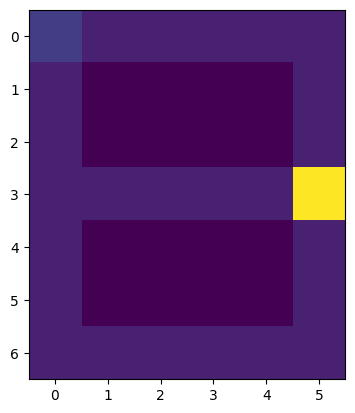

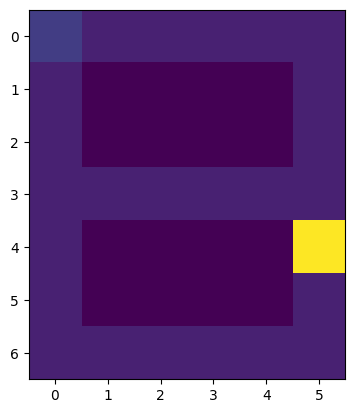

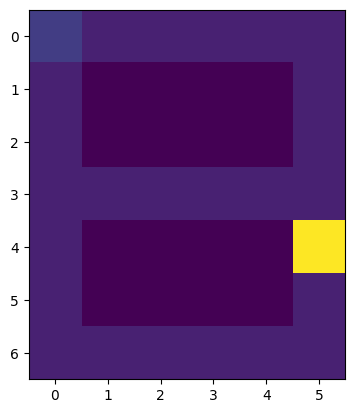

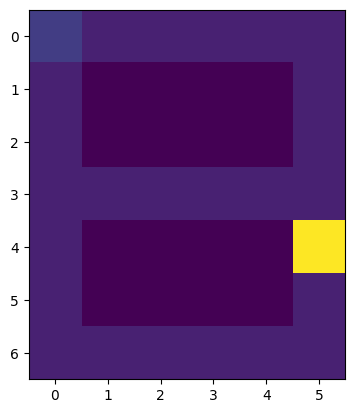

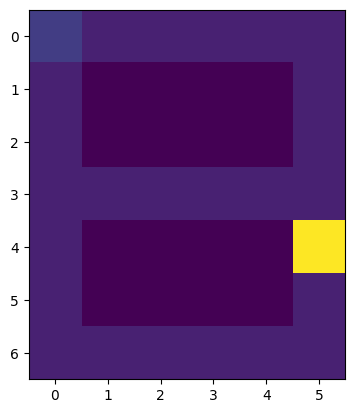

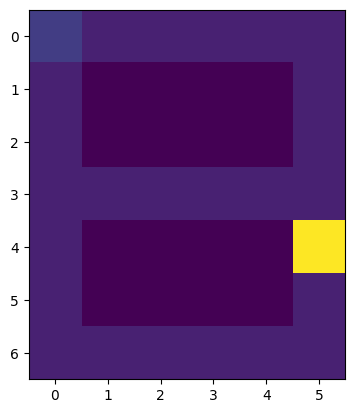

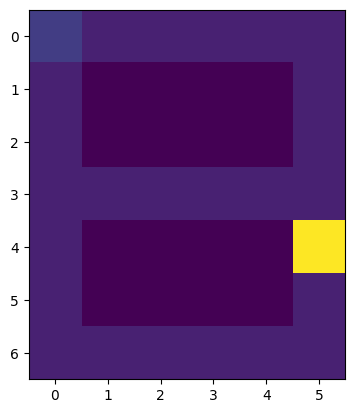

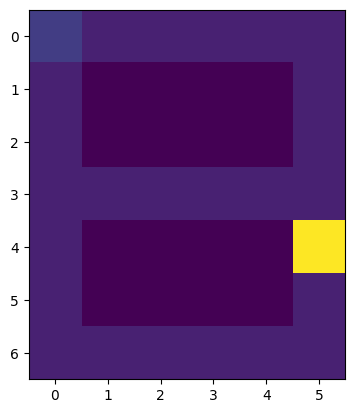

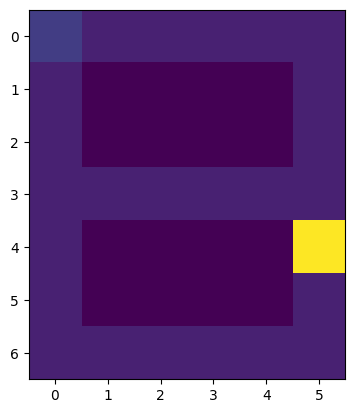

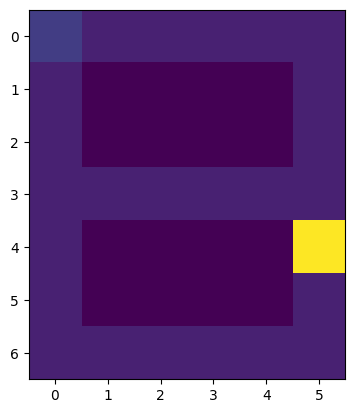

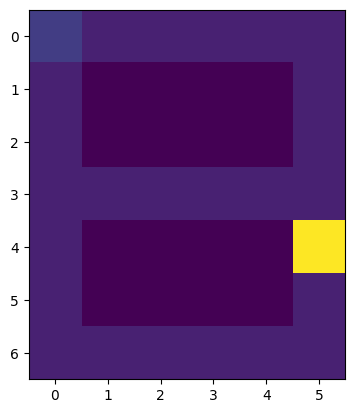

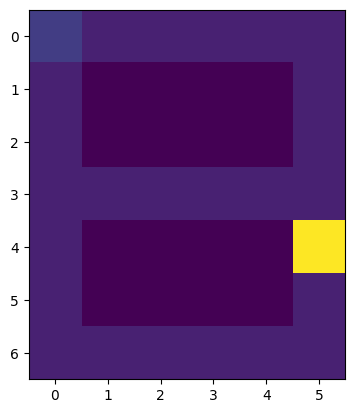

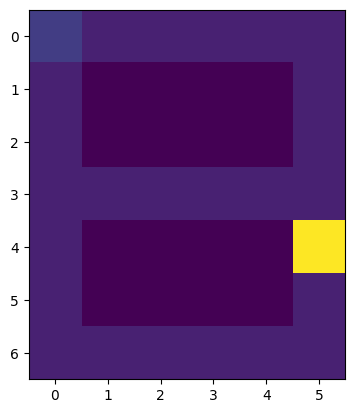

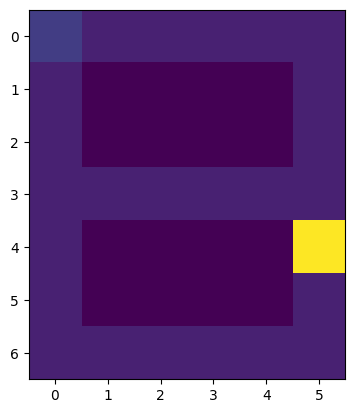

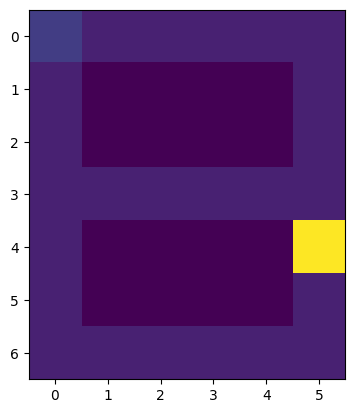

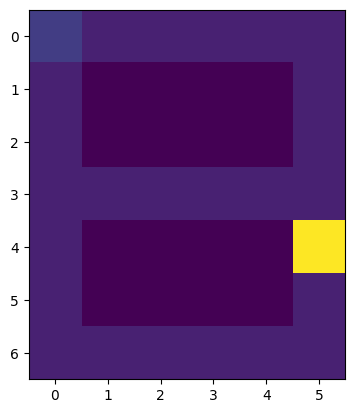

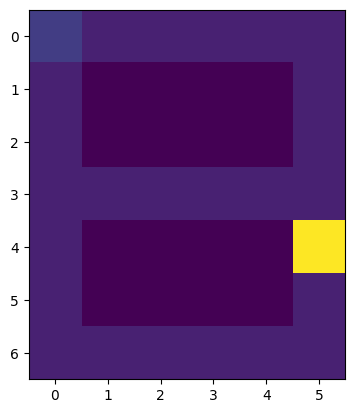

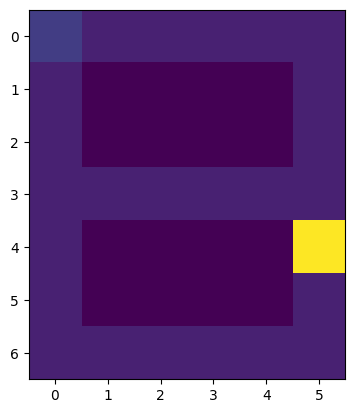

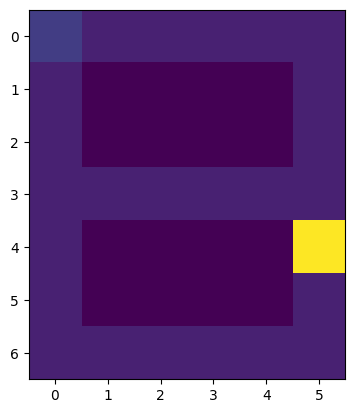

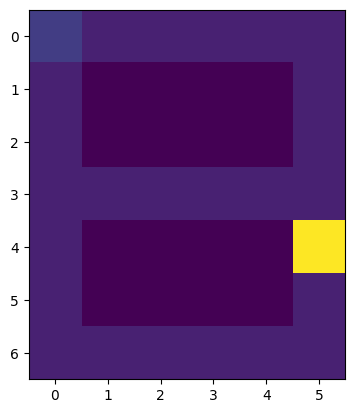

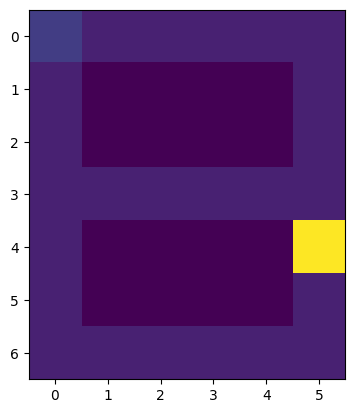

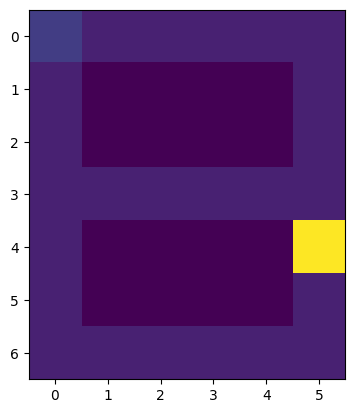

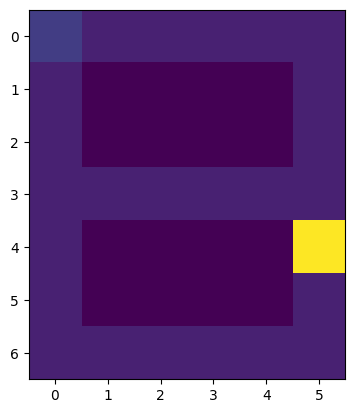

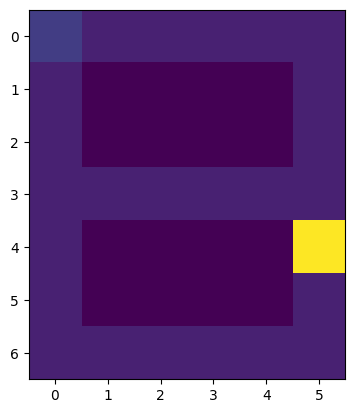

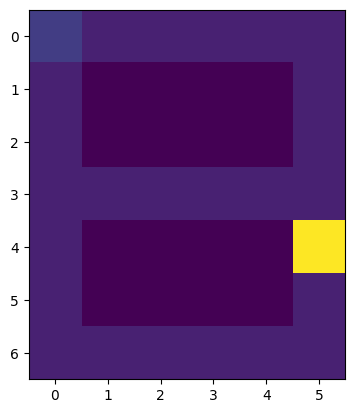

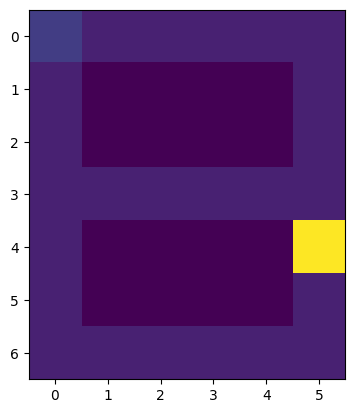

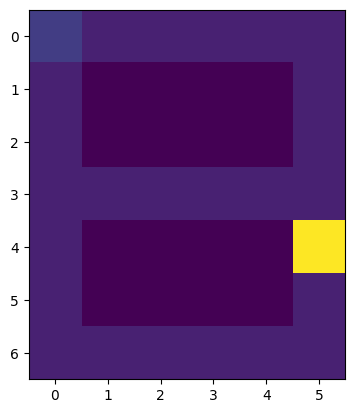

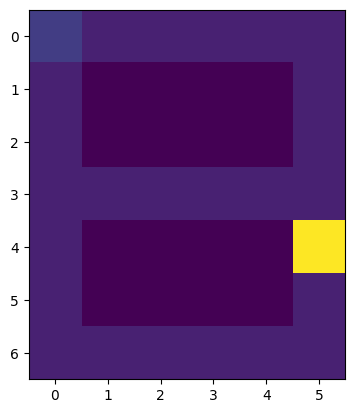

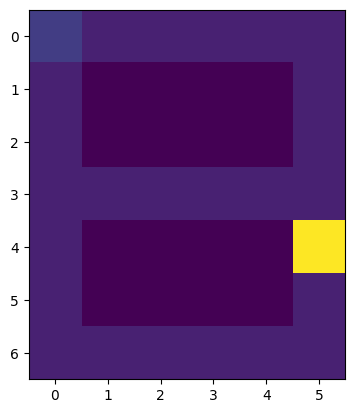

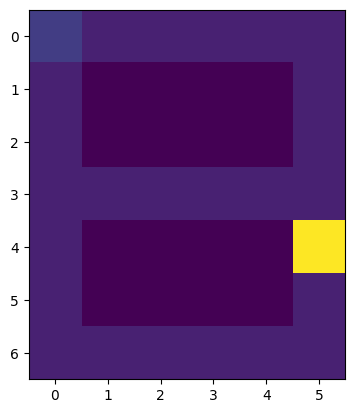

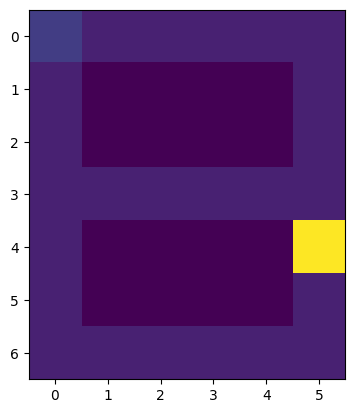

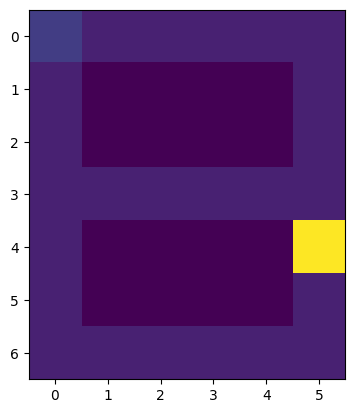

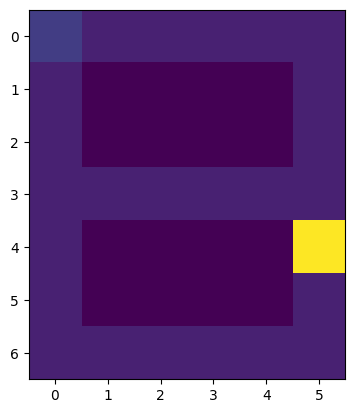

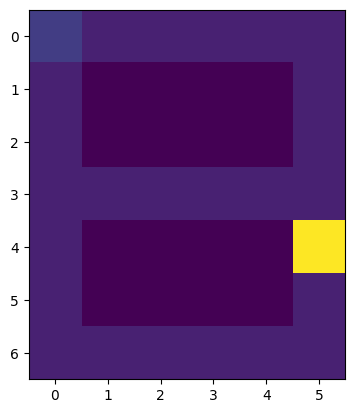

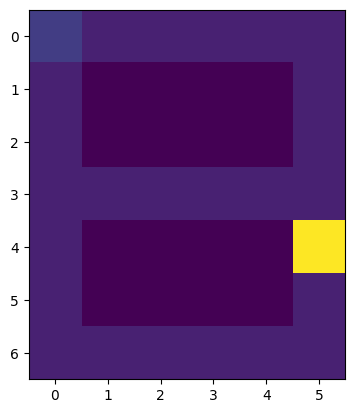

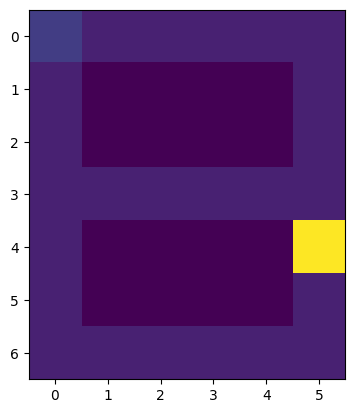

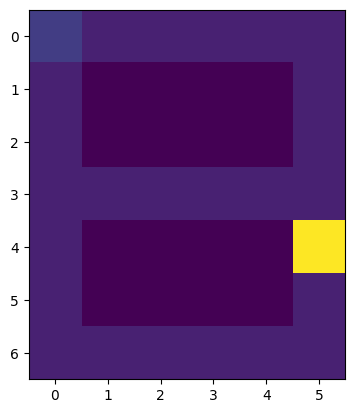

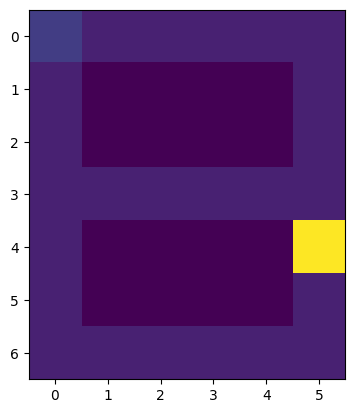

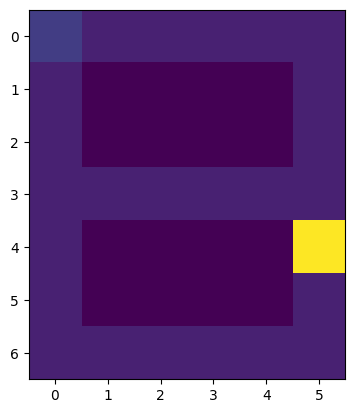

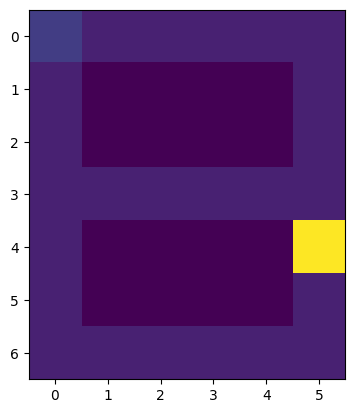

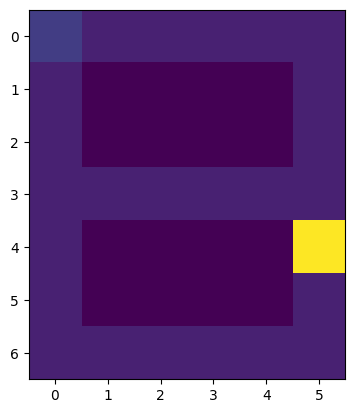

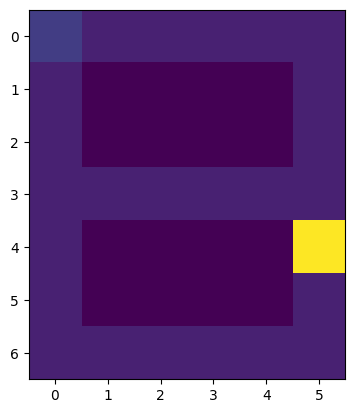

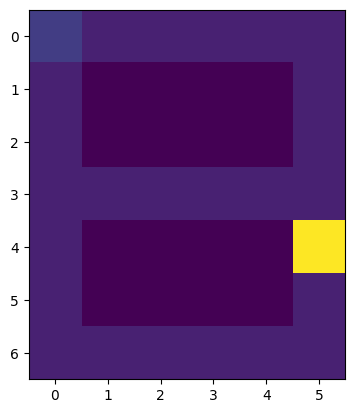

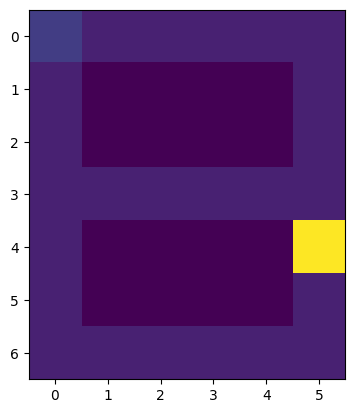

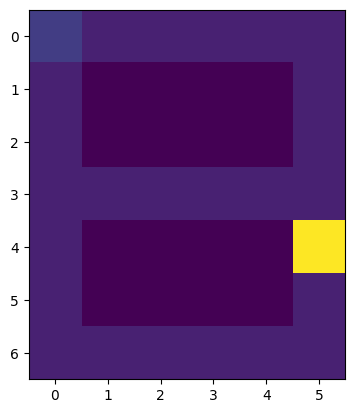

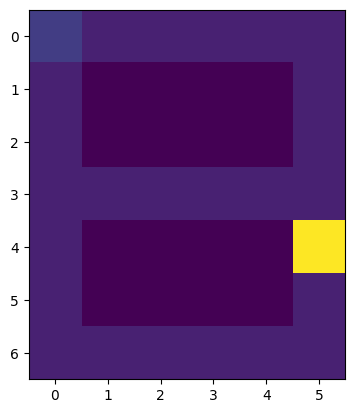

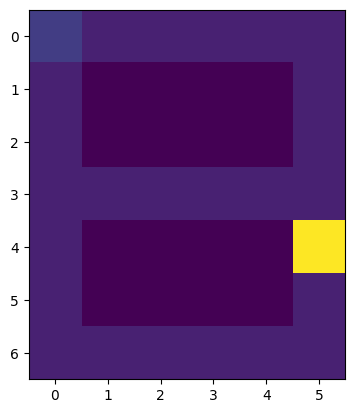

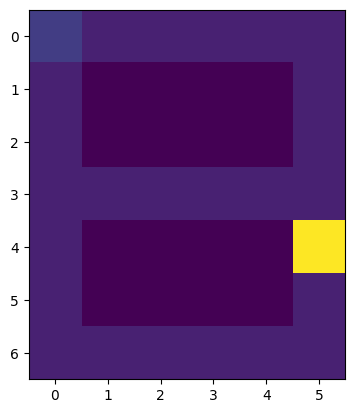

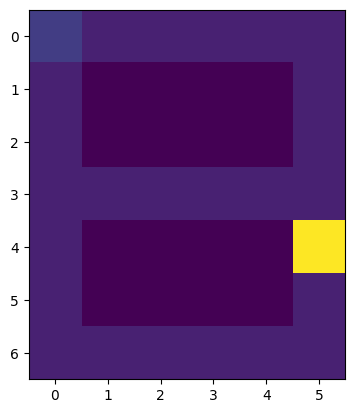

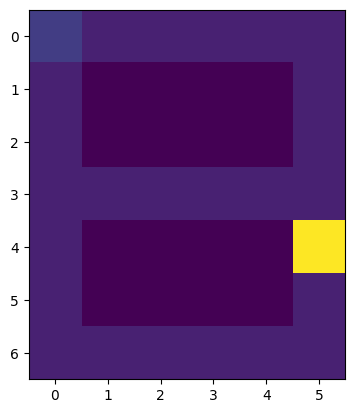

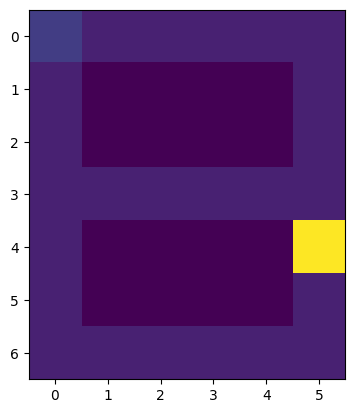

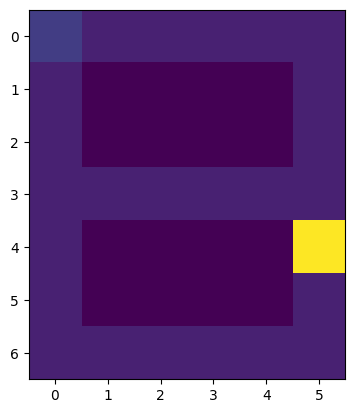

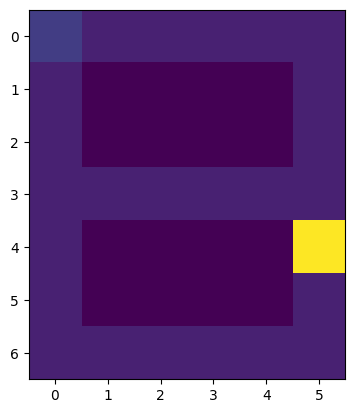

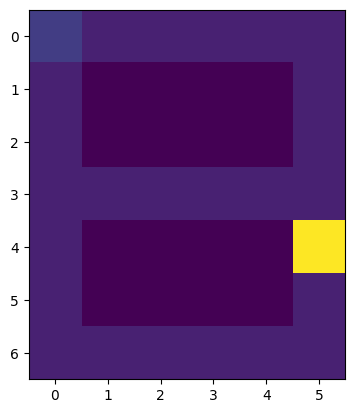

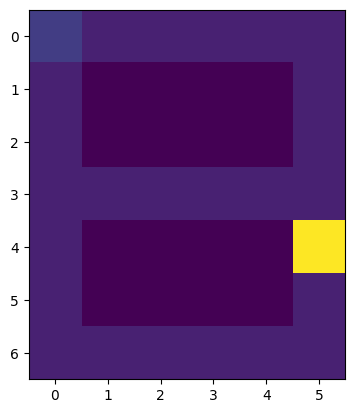

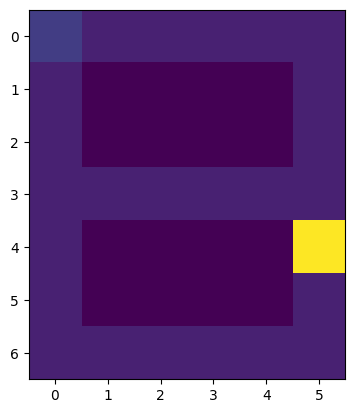

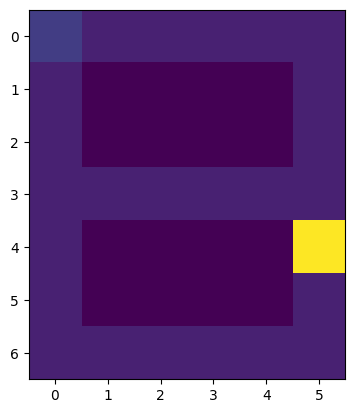

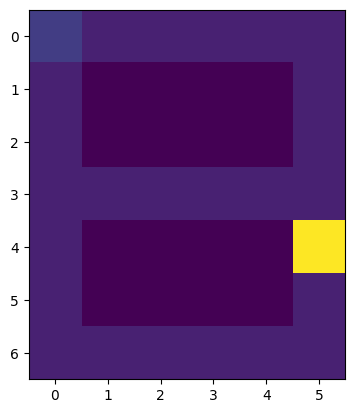

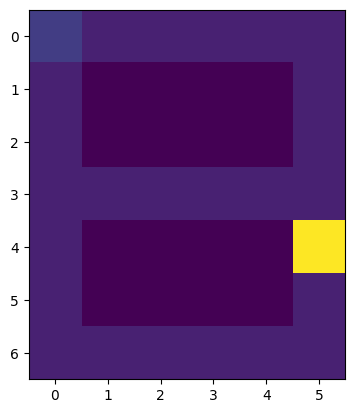

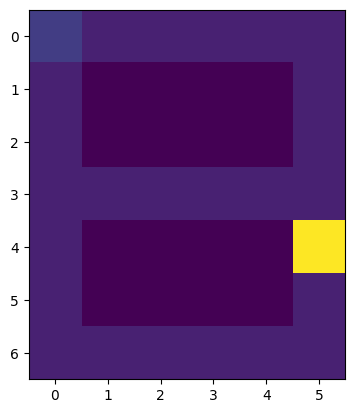

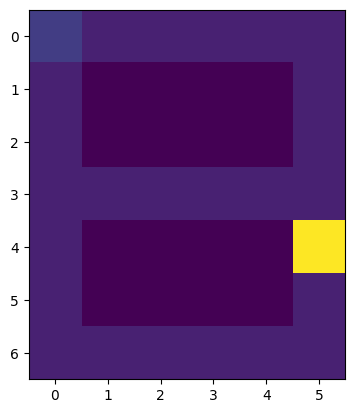

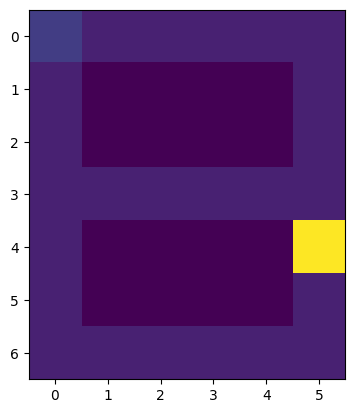

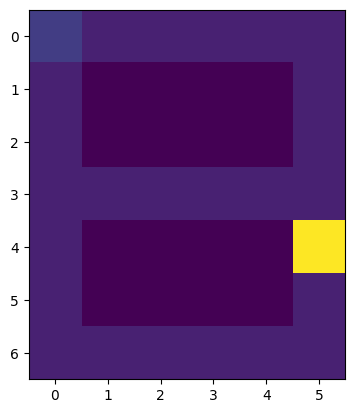

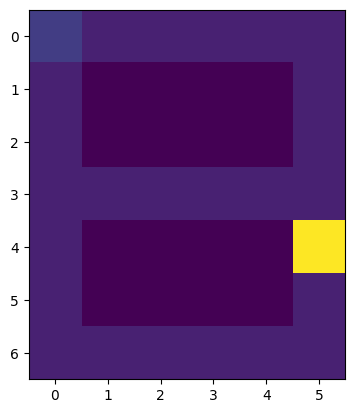

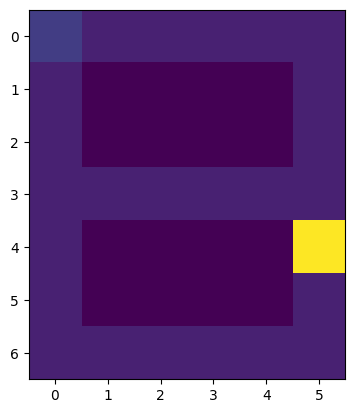

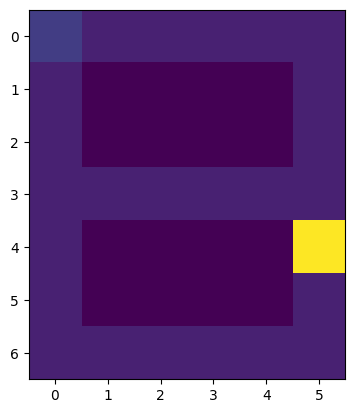

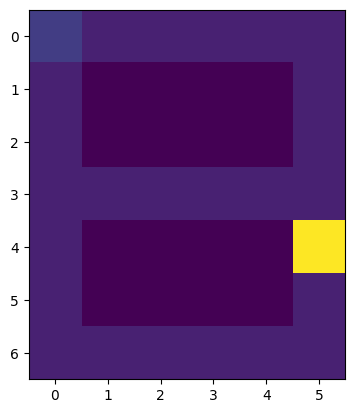

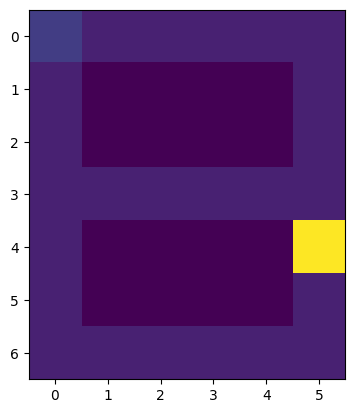

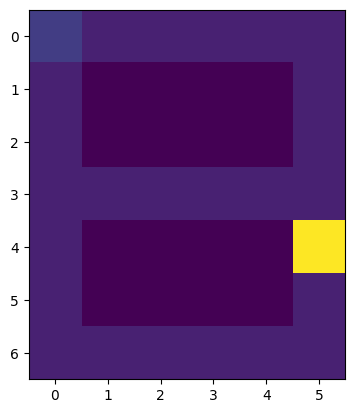

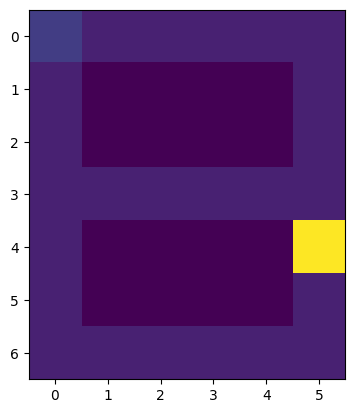

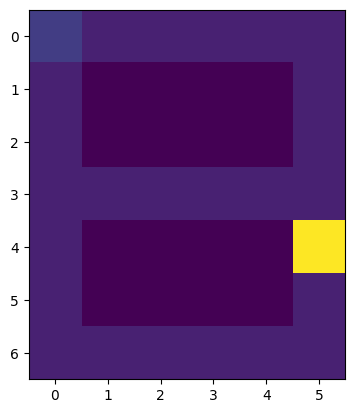

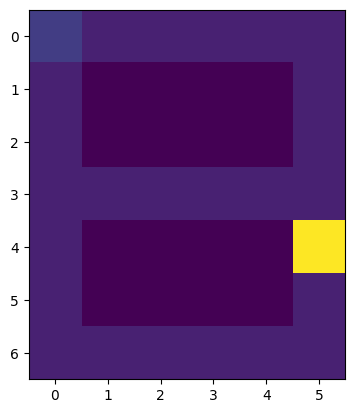

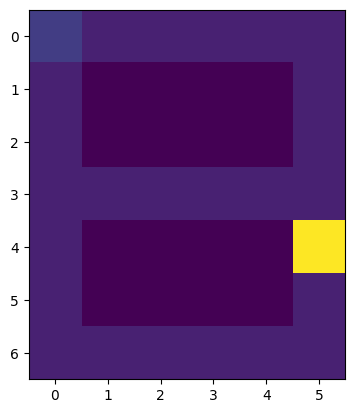

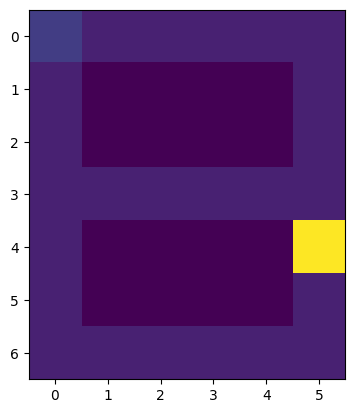

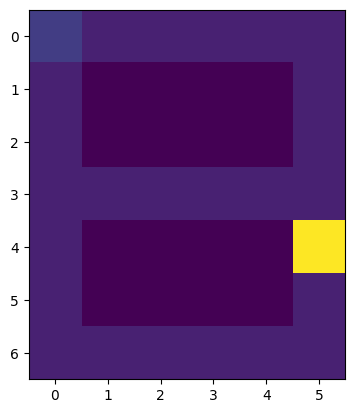

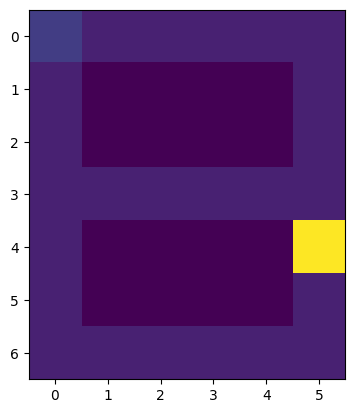

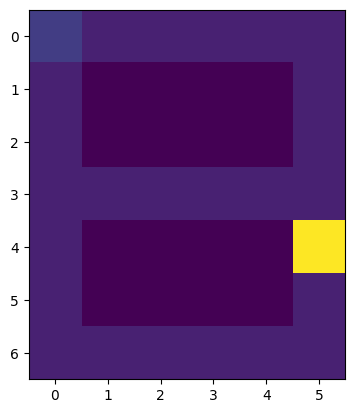

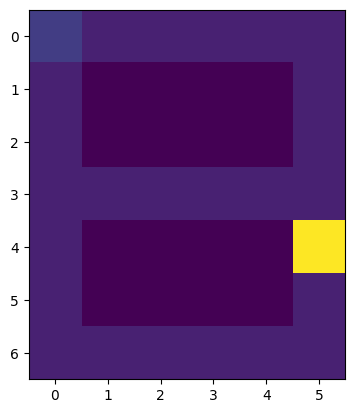

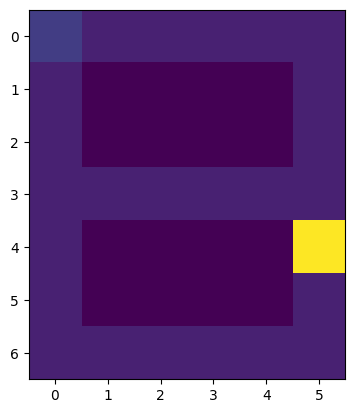

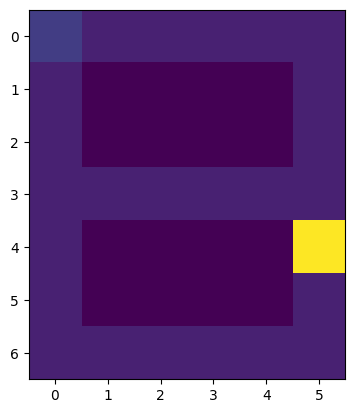

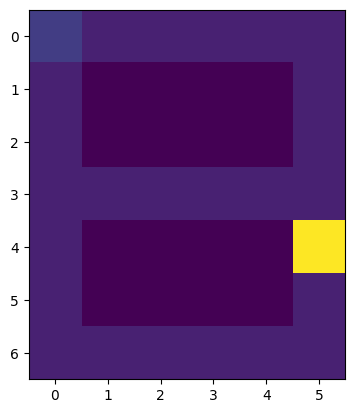

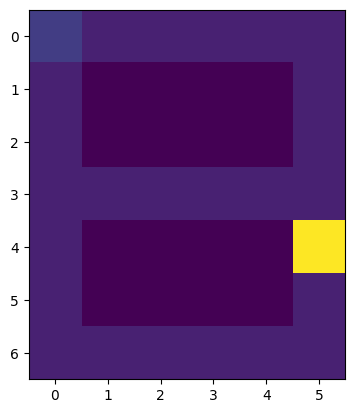

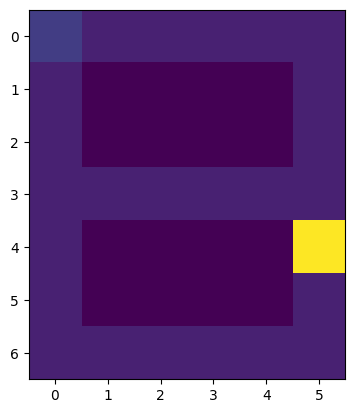

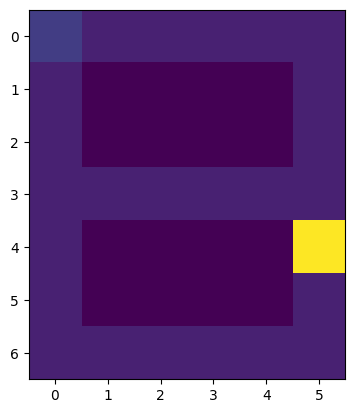

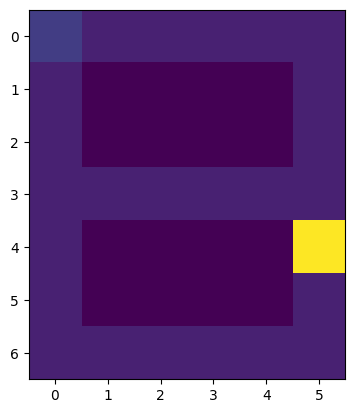

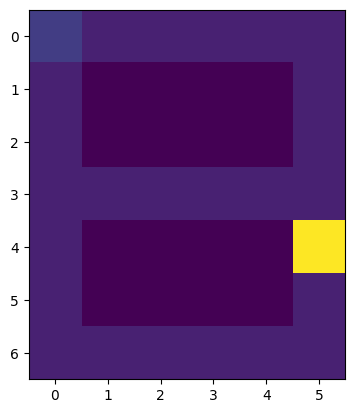

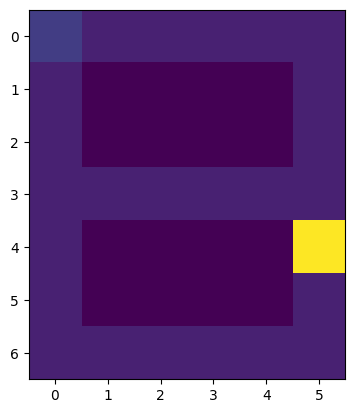

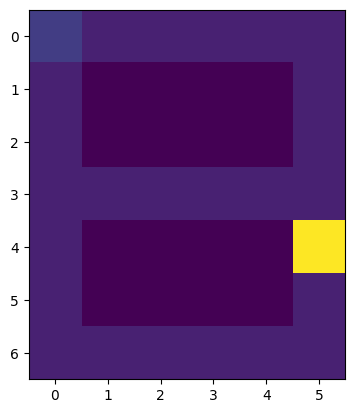

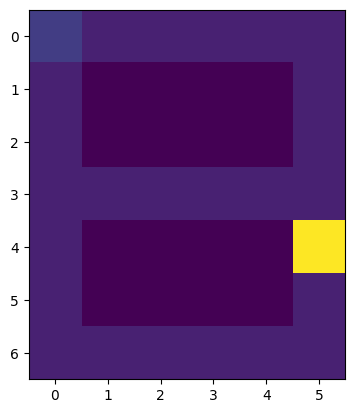

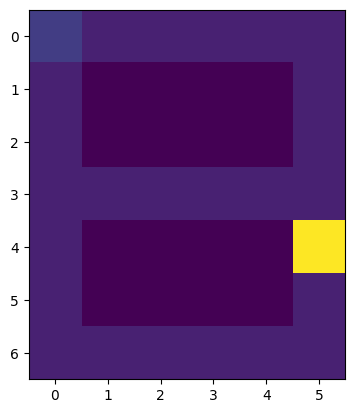

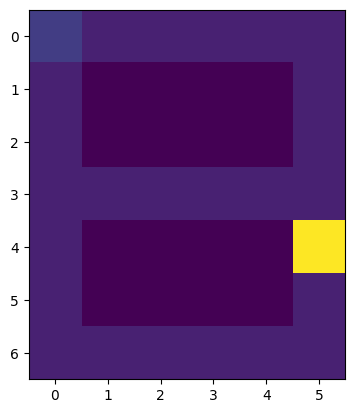

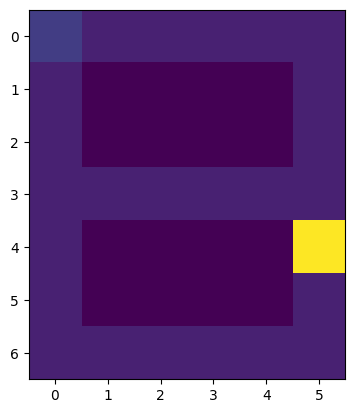

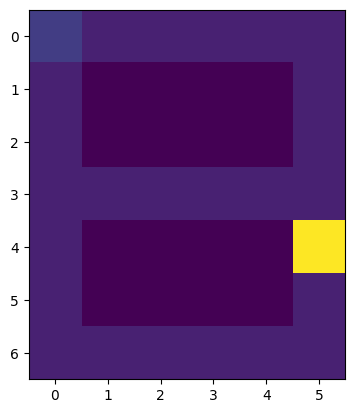

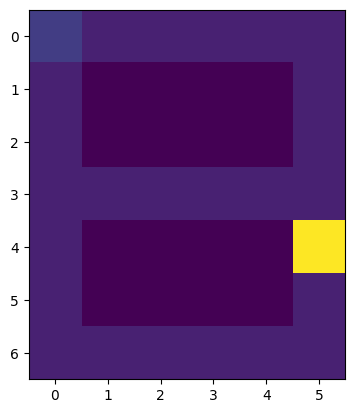

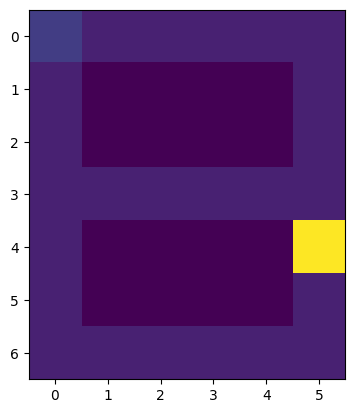

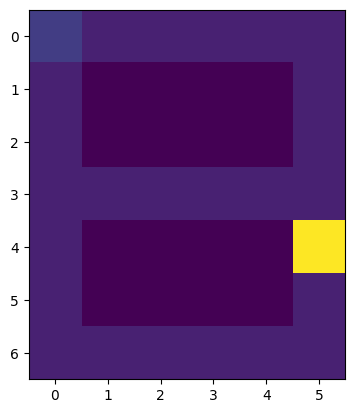

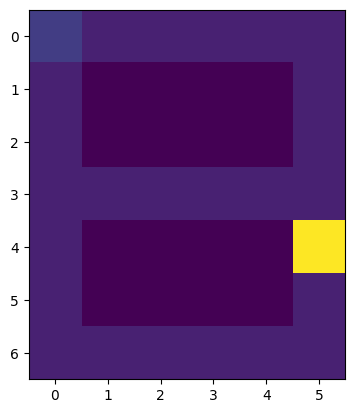

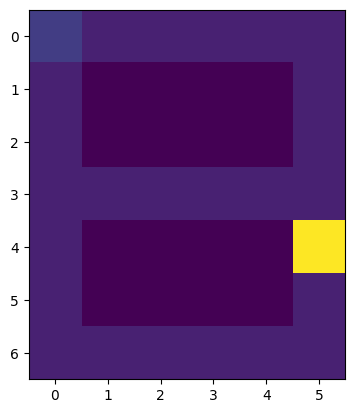

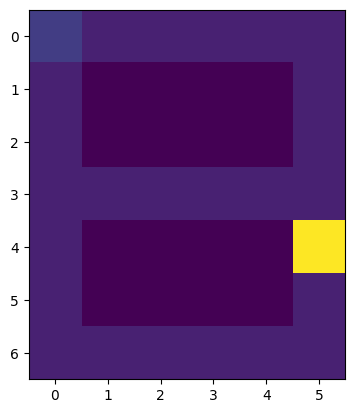

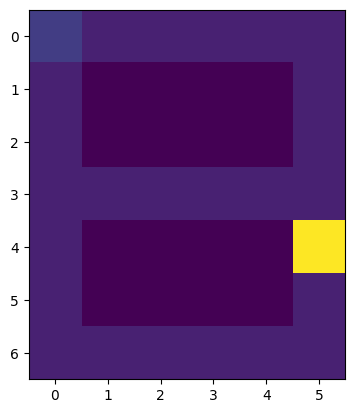

In [12]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((7,6))
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward = agent._step()
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break